In [1]:
import matplotlib.pyplot as plt
from mpl_toolkits.basemap import Basemap
import xarray as xr
import numpy as np
import pandas as pd
import netCDF4 as nc

In [2]:
data = nc.Dataset('Vwind.nc')

In [3]:
data

<class 'netCDF4._netCDF4.Dataset'>
root group (NETCDF4_CLASSIC data model, file format HDF5):
    CDI: Climate Data Interface version 1.9.10 (https://mpimet.mpg.de/cdi)
    Conventions: COARDS
    description: Data is from NMC initialized reanalysis
(4x/day).  It consists of T62 variables interpolated to
pressure surfaces from model (sigma) surfaces.
    platform: Model
    NCO: 20121013
    title: monthly mean vwnd.10m from the NCEP Reanalysis
    dataset_title: NCEP-NCAR Reanalysis 1
    References: http://www.psl.noaa.gov/data/gridded/data.ncep.reanalysis.derived.html
    CDO: Climate Data Operators version 1.9.10 (https://mpimet.mpg.de/cdo)
    history: 11-Dec-2023 06:47:32 Subset NOAA/PSL  
    dimensions(sizes): time(708), lon(192), lat(94)
    variables(dimensions): float64 time(time), float32 lon(lon), float32 lat(lat), float32 vwnd(time, lat, lon)
    groups: 

In [4]:
vwnd = data.variables['vwnd'][:]
vwnd.shape

(708, 94, 192)

In [5]:
lon = data.variables['lon'][:]
lon.shape

(192,)

In [7]:
lat = data.variables['lat'][:]
lat.shape

(94,)

In [8]:
lon_2d, lat_2d = np.meshgrid(lon, lat)


In [9]:
vwnd_slice = vwnd[0, :, :]

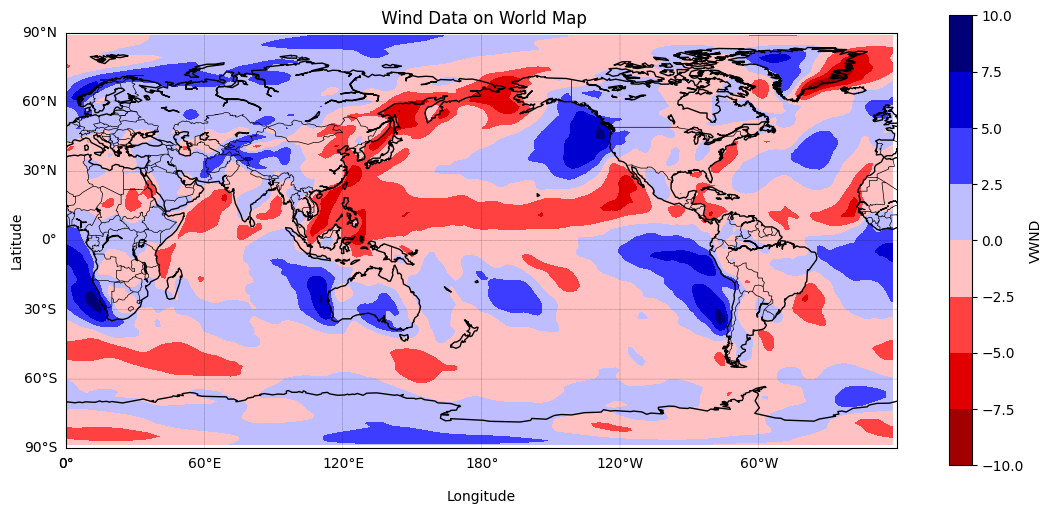

In [12]:
m = Basemap(projection='cyl', llcrnrlat=-90, urcrnrlat=90, llcrnrlon=0, urcrnrlon=360)
x, y = m(lon_2d, lat_2d)

# Create a contour plot
contour = m.contourf(x, y, vwnd_slice, cmap='seismic_r')

# Add coastlines and countries
m.drawcoastlines()
m.drawcountries()

parallels = np.arange(-90., 91., 30.)
meridians = np.arange(-180., 181., 60.)
m.drawparallels(parallels, labels=[True, False, False, True], linewidth=0.2)
m.drawmeridians(meridians, labels=[True, False, False, True], linewidth=0.2)

plt.xlabel('Longitude',labelpad=30)
plt.ylabel('Latitude',labelpad=30)
plt.title(' Wind Data on World Map')
plt.tight_layout()
plt.gcf().set_size_inches(12, 12)
# Add colorbar
cbar = plt.colorbar(contour, label='VWND',shrink=0.4)

# Show the plot
plt.show()


In [13]:
coarse_factor_lat = len(lat) // 18
coarse_factor_lon = len(lon) // 18

# Calculate the shape of the coarsely-gridded array
new_shape_lat = len(lat) // coarse_factor_lat
new_shape_lon = len(lon) // coarse_factor_lon

lat_coarse = lat[:new_shape_lat * coarse_factor_lat:coarse_factor_lat]
lon_coarse = lon[::11]

In [14]:
lat.size

94

In [15]:
lat_coarse

masked_array(data=[ 88.542  ,  79.0435 ,  69.5217 ,  59.9986 ,  50.4752 ,
                    40.9517 ,  31.4281 ,  21.9044 ,  12.3808 ,   2.8571 ,
                    -6.66657, -16.1902 , -25.7139 , -35.2375 , -44.7611 ,
                   -54.2846 , -63.8079 , -73.3307 ],
             mask=False,
       fill_value=1e+20,
            dtype=float32)

In [16]:
lon_coarse

masked_array(data=[  0.   ,  20.625,  41.25 ,  61.875,  82.5  , 103.125,
                   123.75 , 144.375, 165.   , 185.625, 206.25 , 226.875,
                   247.5  , 268.125, 288.75 , 309.375, 330.   , 350.625],
             mask=False,
       fill_value=1e+20,
            dtype=float32)

In [17]:
import numpy as np

def average_lat_lon(data):
    """Averages the latitude and longitude coordinates in a multidimensional array.

    Args:
        data: A multidimensional array with dimensions (years, months, lat, lon).

    Returns:
        A multidimensional array with dimensions (years, months, 18, 18).
    """

    lat_avg_size = data.shape[2] // 18
    lon_avg_size = data.shape[3] // 18

    # Calculate the new shape for latitude and longitude
    new_lat_shape = 18
    new_lon_shape = 18

    # Create an empty array to store the averaged data
    averaged_data = np.zeros((data.shape[0], data.shape[1], new_lat_shape, new_lon_shape))

    # Iterate over latitude and longitude ranges
    for lat_idx in range(new_lat_shape):
        lat_range_start = lat_idx * lat_avg_size
        lat_range_end = (lat_idx + 1) * lat_avg_size

        for lon_idx in range(new_lon_shape):
            lon_range_start = lon_idx * lon_avg_size
            lon_range_end = (lon_idx + 1) * lon_avg_size

            # Select the subset of data for averaging
            subset = data[:, :, lat_range_start:lat_range_end, lon_range_start:lon_range_end]

            # Calculate the average along the latitude and longitude dimensions
            averaged_value = np.mean(subset, axis=(2, 3))

            # Store the averaged data
            averaged_data[:, :, lat_idx, lon_idx] = averaged_value

    return averaged_data




In [18]:
data_reshaped = np.reshape(vwnd, (len(vwnd) // 12, 12, vwnd.shape[1],vwnd.shape[2]))

In [19]:
avg = average_lat_lon(data_reshaped)

In [20]:
avg.shape

(59, 12, 18, 18)

In [21]:
avg = np.reshape(avg, (708,18,18))
avg.shape

(708, 18, 18)

In [22]:
final = np.reshape(avg, (59,12,324))
final.shape

(59, 12, 324)

Text(0.5, 1.0, 'Coarsely Gridded Wind Data on World Map')

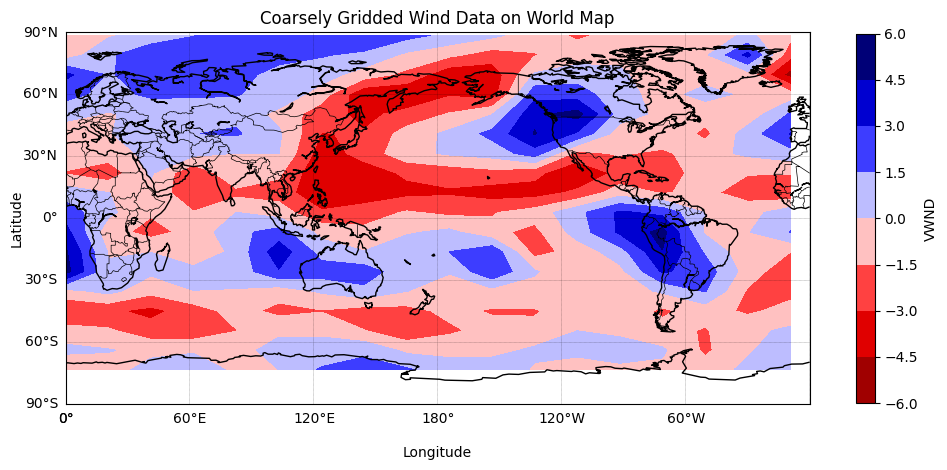

In [23]:
m_coarse = Basemap(projection='cyl', llcrnrlat=-90, urcrnrlat=90, llcrnrlon=0, urcrnrlon=360)

# Create a meshgrid of lon and lat for the coarse grid
lon_2d_coarse, lat_2d_coarse = np.meshgrid(lon_coarse, lat_coarse)

# Convert lon_2d, lat_2d to x, y coordinates for the coarse grid
x_coarse, y_coarse = m_coarse(lon_2d_coarse, lat_2d_coarse)

# Create a contour plot for the coarse grid
contour_coarse = m_coarse.contourf(x_coarse, y_coarse, avg[0,:,:], cmap='seismic_r')

# Add coastlines and countries
m_coarse.drawcoastlines()
m_coarse.drawcountries()

parallels = np.arange(-90., 91., 30.)
meridians = np.arange(-180, 181, 60.)
m.drawparallels(parallels, labels=[True, False, False, True], linewidth=0.2)
m.drawmeridians(meridians, labels=[True, False, False, True], linewidth=0.2)
lon_ticks = np.arange(0, 361, 60)  # Adjust based on your data range
lon_labels = ['{}°E'.format(lon) if lon <= 180 else '{}°W'.format(360 - lon) for lon in lon_ticks]
# Add colorbar
cbar_coarse = plt.colorbar(contour_coarse, label='VWND',shrink=0.4)
plt.gcf().set_size_inches(12, 12)
# Add labels and title
plt.xlabel('Longitude',labelpad=30)
plt.ylabel('Latitude',labelpad=30)
plt.title('Coarsely Gridded Wind Data on World Map')

In [24]:
import numpy as np

def calculate_anomalies_and_normalized_minmax(data):
    """Calculate monthly anomalies and mean for a given dataset.

    Args:
        data: A multidimensional array with dimensions (years, months, latlon).

    Returns:
        monthly_anomalies: An array with monthly anomalies of the same shape as the input data.
        monthly_mean: A multidimensional array with dimensions (months, latlon) representing the mean for each month.
    """


    anomalies = np.zeros((59,12,324))
    for i in range(data.shape[2]):
        for j in range(data.shape[1]):
            month = data[:, j, i]
            monthly_mean = np.mean(month)
            anomalies[:, j, i] = month - monthly_mean
    return anomalies


In [25]:
anomalies = calculate_anomalies_and_normalized_minmax(final)
anomalies

array([[[-0.46764573, -0.01222311,  0.45942886, ..., -1.56323854,
          0.10838258,  1.41917427],
        [ 0.2132379 , -0.35279902, -0.6700487 , ..., -0.71473811,
          0.60784185,  0.87785616],
        [ 0.45316062, -0.35586181, -1.05789284, ..., -0.601449  ,
         -0.15648019,  0.5708955 ],
        ...,
        [ 0.72186559,  0.70505516,  0.60552944, ...,  0.10375765,
          0.25116859,  0.31976101],
        [-0.30263023, -0.00457731,  0.33985337, ..., -0.71689364,
         -0.33417183,  1.73972998],
        [ 0.04854312,  0.22728908,  0.21585885, ..., -1.29866456,
          0.63974441,  1.37401983]],

       [[-1.88229724, -2.57839766, -2.42489378, ..., -0.26282553,
          0.62406641, -0.40231619],
        [-1.04886185, -0.84794923, -0.88149869, ..., -0.57128814,
          0.51784897,  0.82432042],
        [-0.60428484, -1.59765508, -1.68357031, ..., -0.39042316,
          0.15940344,  0.40905   ],
        ...,
        [ 1.16978798,  1.49351966,  1.56188432, ..., -

In [26]:
anomalies = np.reshape(anomalies, (708,18,18))
anomalies.shape

(708, 18, 18)

Text(0.5, 1.0, 'Coarsely Gridded Wind Anomalies Data on World Map')

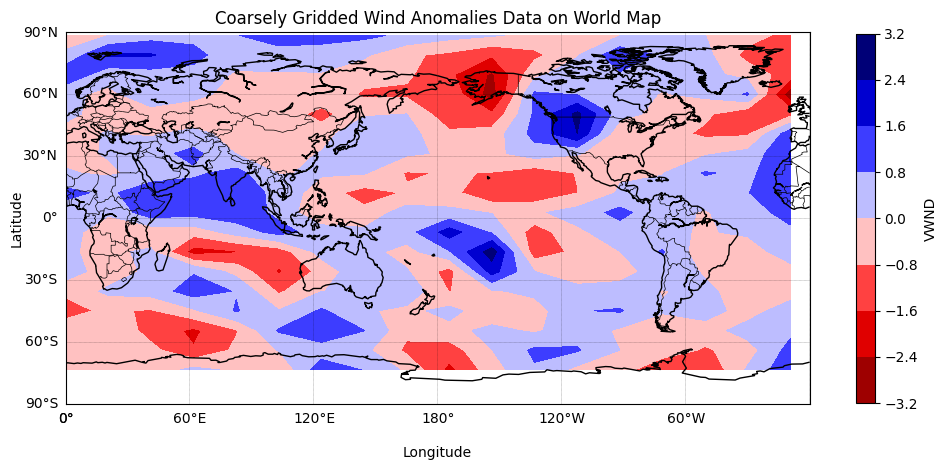

In [27]:
m_coarse = Basemap(projection='cyl', llcrnrlat=-90, urcrnrlat=90, llcrnrlon=0, urcrnrlon=360)

# Create a meshgrid of lon and lat for the coarse grid
lon_2d_coarse, lat_2d_coarse = np.meshgrid(lon_coarse, lat_coarse)

# Convert lon_2d, lat_2d to x, y coordinates for the coarse grid
x_coarse, y_coarse = m_coarse(lon_2d_coarse, lat_2d_coarse)

# Create a contour plot for the coarse grid
contour_coarse = m_coarse.contourf(x_coarse, y_coarse, anomalies[0,:,:], cmap='seismic_r')

# Add coastlines and countries
m_coarse.drawcoastlines()
m_coarse.drawcountries()

parallels = np.arange(-90., 91., 30.)
meridians = np.arange(-180, 181, 60.)
m.drawparallels(parallels, labels=[True, False, False, True], linewidth=0.2)
m.drawmeridians(meridians, labels=[True, False, False, True], linewidth=0.2)
lon_ticks = np.arange(0, 361, 60)  # Adjust based on your data range
lon_labels = ['{}°E'.format(lon) if lon <= 180 else '{}°W'.format(360 - lon) for lon in lon_ticks]
# Add colorbar
cbar_coarse = plt.colorbar(contour_coarse, label='VWND',shrink=0.4)
plt.gcf().set_size_inches(12, 12)
# Add labels and title
plt.xlabel('Longitude',labelpad=30)
plt.ylabel('Latitude',labelpad=30)
plt.title('Coarsely Gridded Wind Anomalies Data on World Map')